#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 18
**CH18 Forecasting daily ticket sales for a swimming pool**

using swim data

version 0.9.0 2025-08-14

In [1]:
import os
import sys
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import pyfixest as pf
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import root_mean_squared_error

warnings.filterwarnings("ignore")

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/swim-transactions/clean/"
data_out = dirname + "da_case_studies/ch18-swim-transactions/"
output = dirname + "da_case_studies/ch18-swim-transactions/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [3]:
import py_helper_functions as da

# Set custom color scheme for plots
sns.set_theme(rc=da.da_theme, palette=da.color)

### Read data

In [4]:
daily_agg = pd.read_csv(os.path.join(data_in, "swim_work.csv"), parse_dates=["date"])
# daily_agg = pd.read_csv("https://osf.io/download/jcxmk/", parse_dates=["date"])

In [5]:
daily_agg.head()

,date,QUANTITY
0,2010-01-01,0
1,2010-01-02,49
2,2010-01-03,31
3,2010-01-04,14
4,2010-01-05,18


In [6]:
daily_agg["year"] = daily_agg["date"].dt.year
daily_agg["quarter"] = daily_agg["date"].dt.quarter
daily_agg["month"] = daily_agg["date"].dt.month
daily_agg["day"] = daily_agg["date"].dt.day
daily_agg["dow"] = daily_agg["date"].dt.dayofweek + 1
daily_agg["weekend"] = daily_agg["dow"].isin([6, 7])

In [7]:
daily_agg["school_off"] = (
    ((daily_agg["day"] > 15) & (daily_agg["month"] == 5) & (daily_agg["day"] <= 30))
    | ((daily_agg["month"] == 6) | (daily_agg["month"] == 7))
    | ((daily_agg["day"] < 15) & (daily_agg["month"] == 8))
    | ((daily_agg["day"] > 20) & (daily_agg["month"] == 12))
)

In [8]:
daily_agg["trend"] = daily_agg.index + 1

In [9]:
# Get holiday calendar ----------------------------------

In [10]:
nyse = mcal.get_calendar("NYSE")

holidays = nyse.holidays().holidays

daily_agg["isHoliday"] = daily_agg["date"].isin(holidays)

In [11]:
daily_agg.describe()

,date,QUANTITY,year,quarter,month,day,dow,trend
count,2557,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000
mean,2013-07-02 00:00:00,47.867032,2013.000782,2.508408,6.522487,15.730935,4.001173,1279.000000
min,2010-01-01 00:00:00,0.000000,2010.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2011-10-02 00:00:00,14.000000,2011.000000,2.000000,4.000000,8.000000,2.000000,640.000000
50%,2013-07-02 00:00:00,28.000000,2013.000000,3.000000,7.000000,16.000000,4.000000,1279.000000
75%,2015-04-02 00:00:00,64.000000,2015.000000,4.000000,10.000000,23.000000,6.000000,1918.000000
max,2016-12-31 00:00:00,287.000000,2016.000000,4.000000,12.000000,31.000000,7.000000,2557.000000
std,NaN,50.491050,2.000587,1.117346,3.449499,8.802361,2.000097,738.286643


### Define vars for analysis

### 📘 Bellonda's Logic Decoder: Feature Engineering - Baselines & Logs

**1. The Strategy:**
We are preparing the dataset for regression analysis. Raw numbers (Quantity) can be noisy and skewed. By converting them to **Logs**, we normalize distributions. By creating **Group Means** (Baselines), we allow the model to compare a specific day against the "expected average" for that time of year.

**2. Syntax Breakdown:**

| Code Segment | Role | Meaning |
| :--- | :--- | :--- |
| `.groupby(...).transform("mean")` | **The Broadcaster** | Calculates a group average and assigns it back to every original row in that group. Preserves DataFrame length. |
| `np.log(...)` | **The Linearizer** | Compresses the scale. Turns multiplicative relationships (exponential growth) into additive ones (lines). |
| `.replace([np.inf, -np.inf], np.nan)` | **The Safety Valve** | `log(0)` is negative infinity. This breaks models. We treat these as missing data (NaN) instead. |
| `.dt.day_name().str[:3]` | **The Formatter** | Extracts the Day Name (Monday) and slices the first 3 chars (Mon). Essential for clean plots. |

**3. Critical Note:**
> [!TIP]
> **Why Transform?**
> We use `.transform()` here because we are **enriching** the original dataset, not summarizing it. We want to keep every single daily observation (row), but add a new column that tells us "What is the average traffic for this month?". This allows us to calculate residuals (Actual - Average) later.

**4. Data Shape Check:**
Input: `(Daily Rows, K Cols)` $\to$ Output: `(Daily Rows, K + 5 Cols)`
*   Rows remain unchanged.
*   5 new features added: `q_month`, `q_ln`, `tickets` (granular avg), `tickets_ln`, `dow_abb`, `month_abb`.

In [12]:
daily_agg["q_month"] = daily_agg.groupby("month")["QUANTITY"].transform("mean")

daily_agg["q_ln"] = np.log(daily_agg["QUANTITY"])

# Replace inf values with NaN
daily_agg["q_ln"] = daily_agg["q_ln"].replace([np.inf, -np.inf], np.nan)

daily_agg["tickets"] = daily_agg.groupby(["month", "dow"])["QUANTITY"].transform("mean")

daily_agg["tickets_ln"] = daily_agg.groupby(["month", "dow"])["q_ln"].transform("mean")

daily_agg["dow_abb"] = daily_agg["date"].dt.day_name().str[:3]

daily_agg["month_abb"] = daily_agg["date"].dt.month_name().str[:3]

## Descriptive graphs

### 📘 Bellonda's Logic Decoder: Single-Year Trend Inspection

**1. The Strategy:**
Before modeling, we must visually confirm our "Priors" (hypotheses). For a swimming pool, we expect low sales in winter and high sales in summer. We isolate 2015 to verify this "Heartbeat" of the business without the distraction of multi-year trends.

**2. Syntax Breakdown:**

| Code Segment | Role | Meaning |
| :--- | :--- | :--- |
| `daily_agg["year"] == 2015` | **The Sieve** | A boolean mask that returns `True` only for rows in 2015. |
| `.reset_index()` | **The Flattener** | often required by Seaborn to access the index (Date) as a regular column named "date" or "index". |
| `strftime("%d%b%Y")` | **The Formatter** | "01Jan2015". Turns computer timestamps into business-friendly text. |
| `linewidth=0.6` | **The Thinner** | Reduces line thickness. Essential for volatility plots to distinguish individual days. |

**3. Critical Note:**
> [!TIP]
> **Manual Ticking:**
> Python's automatic date labeling is often "too smart for its own good," picking awkward intervals. By defining `date_ticks` manually, we force the chart to align with **Quarterly boundaries** (Jan, Apr, Jul, Oct), which is how businesses typically track performance.

**4. Data Shape Check:**
Input: `(Full DataFrame)` $\to$ Output: `(Subset of ~365 rows)` $\to$ `(Line Chart)`

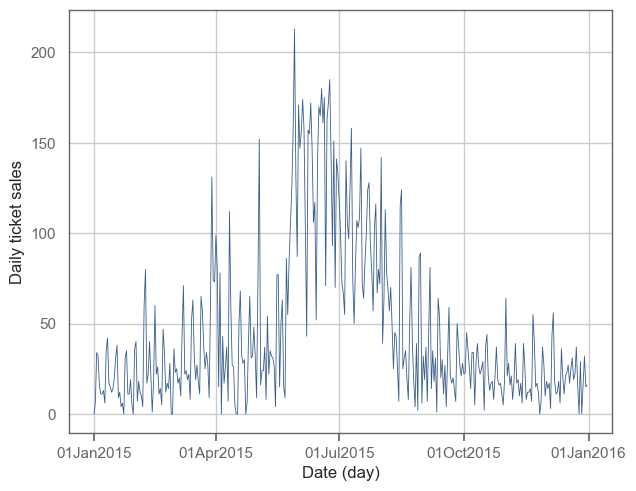

In [13]:
filtered_data = daily_agg[daily_agg["year"] == 2015].reset_index()

sns.lineplot(data=filtered_data, x="date", y="QUANTITY", linewidth=0.6)
date_ticks = ["2015-01-01", "2015-04-01", "2015-07-01", "2015-10-01", "2016-01-01"]
plt.xticks(date_ticks, [pd.to_datetime(date).strftime("%d%b%Y") for date in date_ticks])
plt.xlabel("Date (day)")
plt.ylabel("Daily ticket sales")
plt.show()

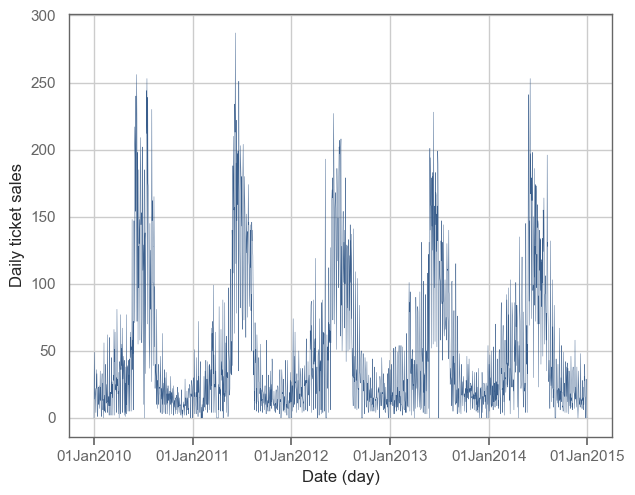

In [14]:
filtered_data = daily_agg.loc[
    (daily_agg.year >= 2010) & (daily_agg.year <= 2014), :
].reset_index()

sns.lineplot(data=filtered_data, x="date", y="QUANTITY", linewidth=0.3)
date_ticks = [
    "2010-01-01",
    "2011-01-01",
    "2012-01-01",
    "2013-01-01",
    "2014-01-01",
    "2015-01-01",
]
plt.xticks(date_ticks, [pd.to_datetime(date).strftime("%d%b%Y") for date in date_ticks])
plt.xlabel("Date (day)")
plt.ylabel("Daily ticket sales")
plt.show()

### 📘 Bellonda's Logic Decoder: Monthly Volatility Profiling

**1. The Strategy**
We are performing a **Distribution Analysis**. An average is misleading; a month with 100 sales every day and a month with 0 and 200 sales alternating have the same average. The **Boxplot** reveals the truth:
*   **The Box (IQR):** Where the middle 50% of business happens.
*   **The Whiskers:** Use to detect "Normal" range.
*   **The Fliers (Dots):** Extraordinary events (Heatwaves? Holidays?).

**2. Syntax Breakdown**
| Code Segment | The Role | The Plain English Translation |
| :--- | :--- | :--- |
| `order=month_order` | **The Enforcer** | Overrides Python's default alphabetical sort (Apr, Aug...) to strictly follow Calendar logic. |
| `flierprops` | **The Highlighter** | Controls the style of outliers (dots). We use `alpha` (transparency) to spot clusters of extreme days. |
| `showcaps=False` | **The Eraser** | Removes the T-bars at the end of whiskers. A "Tufte-style" choice to maximize the Data-Ink ratio. |
| `plt.grid(axis="x")` | **The Guide** | Adds vertical lines. Helps the eye trace a specific month up and down without losing its place. |

**3. Critical Note**
> [!TIP]
> **Why Boxplots?**
> We use Boxplots over Bar Charts here because Bar Charts hide variance. In a business dependent on weather (swimming pools), knowing the **variance** (the height of the box) is just as important as knowing the mean.

**4. Data Shape Check**
Input `(Daily Data)` ➡️ Output `(12 Distribution Summaries)`

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


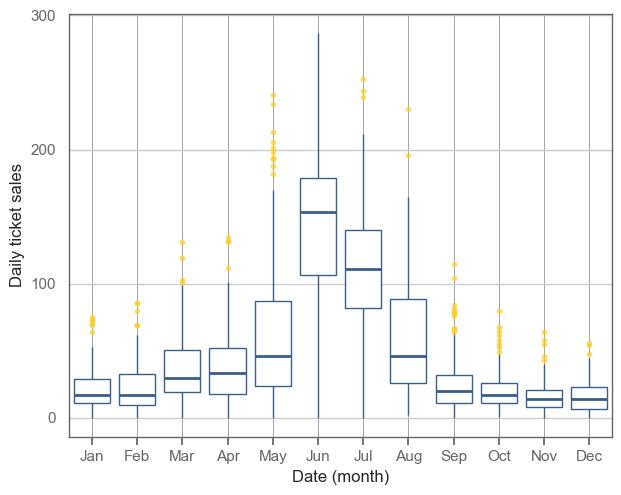

In [15]:
month_order = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]
sns.boxplot(
    data=daily_agg,
    x="month_abb",
    y="QUANTITY",
    fliersize=3,
    order=month_order,
    flierprops={
        "markerfacecolor": da.color[3],
        "markeredgecolor": da.color[3],
        "alpha": 0.6,
    },
    boxprops={"facecolor": "white", "edgecolor": da.color[0]},
    whiskerprops={"color": da.color[0]},
    medianprops={"color": da.color[0], "linewidth": 2},
    showcaps=False,
)
plt.yticks(np.arange(0, 400, 100))
plt.xlabel("Date (month)")
plt.ylabel("Daily ticket sales")
plt.grid(axis="x", color="gray", linestyle="-", linewidth=0.5)
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


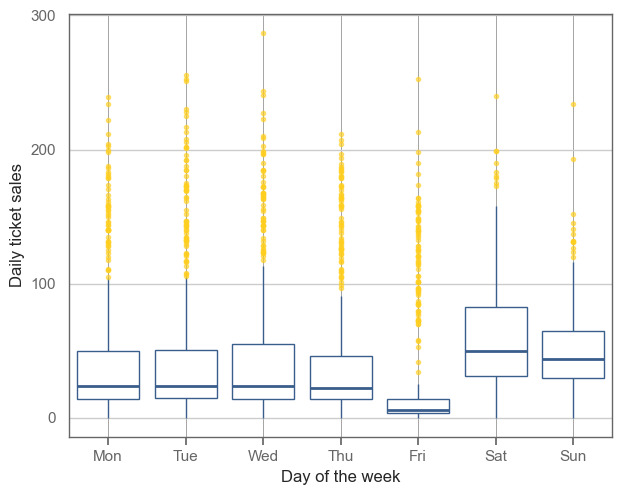

In [16]:
dow_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.boxplot(
    data=daily_agg,
    x="dow_abb",
    y="QUANTITY",
    fliersize=3,
    order=dow_order,
    flierprops={
        "markerfacecolor": da.color[3],
        "markeredgecolor": da.color[3],
        "alpha": 0.6,
    },
    boxprops={"facecolor": "white", "edgecolor": da.color[0]},
    whiskerprops={"color": da.color[0]},
    medianprops={"color": da.color[0], "linewidth": 2},
    showcaps=False,
)
plt.yticks(np.arange(0, 400, 100))
plt.xlabel("Day of the week")
plt.ylabel("Daily ticket sales")
plt.grid(axis="x", color="gray", linestyle="-", linewidth=0.5)
plt.show()

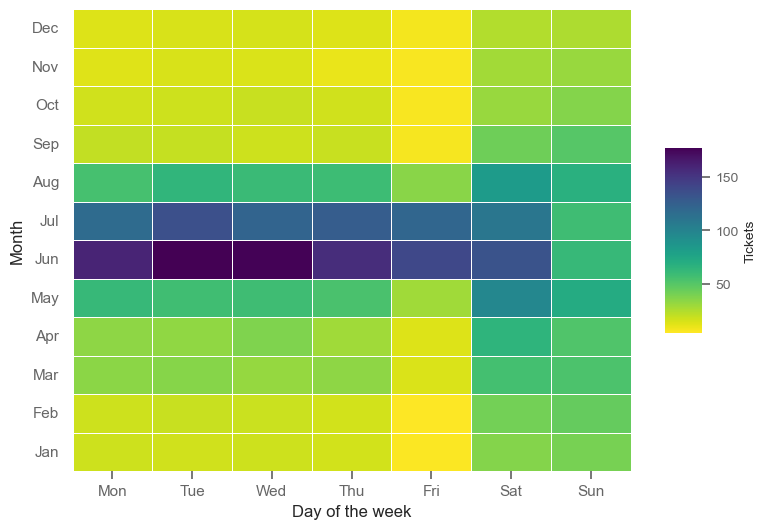

In [17]:
# ---------------------------------------------------------
# ACT 2: INTERACTION ANALYSIS (HEATMAP)
# Goal: Visualize how Day-of-Week patterns change across Months
# ---------------------------------------------------------

# 1. Initialize the blank canvas with a specific aspect ratio
plt.figure(figsize=(9, 6))

# 2. ENFORCE LOGICAL ORDERING (Crucial Step)
# By default, Python sorts alphabetically (Apr -> Aug -> Dec).
# We must force it to respect the Calendar (Monday -> Sunday, Dec -> Jan).
daily_agg["dow_abb_ordered"] = pd.Categorical(
    daily_agg["dow_abb"], 
    categories=dow_order,  # defined earlier: ['Mon', 'Tue', ...]
    ordered=True
)

# We reverse the month order here because heatmaps build from the bottom-up.
# Reversing ensures "Jan" is at the top/bottom as intended visually.
daily_agg["month_abb_ordered"] = pd.Categorical(
    daily_agg["month_abb"], 
    categories=reversed(month_order), # defined earlier: ['Jan', 'Feb', ...]
    ordered=True
)

# 3. PREPARE THE DATA (The "Group & Aggregate" Phase)
# We need one single number (mean) for every (Month, Day) combination.
# Result: 84 rows (12 months * 7 days).
agg_data = daily_agg.groupby(
    ["month_abb_ordered", "dow_abb_ordered"], 
    as_index=False
)["tickets"].mean()

# 4. RESHAPE THE DATA (The "Pivot" Phase)
# Heatmaps require a Matrix (Grid) structure, not a List of rows.
# Rows = Months, Columns = Days, Cells = Ticket Sales.
heatmap_data = agg_data.pivot(
    index="month_abb_ordered", 
    columns="dow_abb_ordered", 
    values="tickets"
)

# 5. VISUALIZE (The "Painting" Phase)
sns.heatmap(
    heatmap_data,
    cmap="viridis_r",         # Color scheme (reversed to make high sales stand out)
    linewidths=0.5,           # White gridlines to separate cells
    linecolor="white",
    cbar_kws={"shrink": 0.4, "aspect": 5}, # Make the legend smaller/tighter
)

# 6. POLISH THE CHART
plt.xlabel("Day of the week")
plt.ylabel("Month")
plt.yticks(rotation=0)        # Keep axis labels horizontal for readability

# 7. CUSTOMIZE THE COLORBAR (The Legend)
# Access the colorbar object directly to change font size and ticks.
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.set_label("Tickets", fontsize=10)
cbar.set_ticks([50, 100, 150]) # Set nice, round number anchors

plt.show()

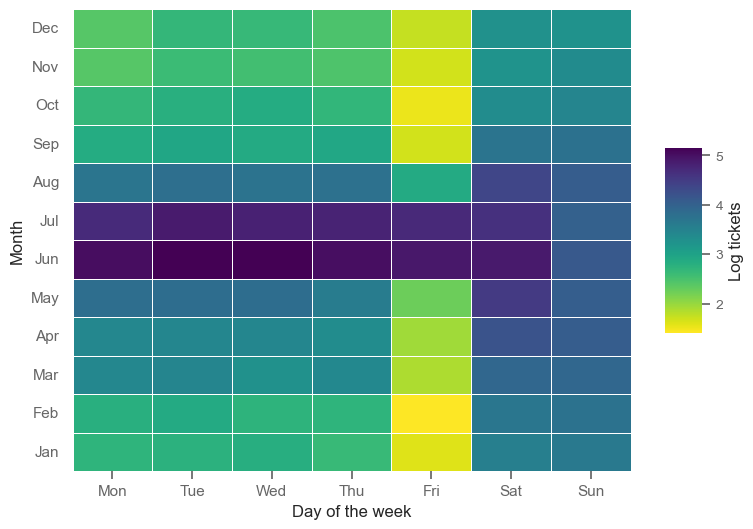

In [18]:
# not in book
plt.figure(figsize=(9, 6))
agg_data = daily_agg.groupby(["month_abb_ordered", "dow_abb_ordered"], as_index=False)[
    "tickets_ln"
].mean()

heatmap_data = agg_data.pivot(
    index="month_abb_ordered", columns="dow_abb_ordered", values="tickets_ln"
)

sns.heatmap(
    heatmap_data,
    cmap="viridis_r",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"shrink": 0.4, "aspect": 5, "label": "Log tickets"},
)

plt.xlabel("Day of the week")
plt.ylabel("Month")
plt.yticks(rotation=0)

cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=10)

plt.show()

## Prediction

### Creat train/holdout data

### 📘 Bellonda's Logic Decoder: Encoding & Temporal Splitting

**1. The Strategy**
We are performing two critical setup steps:
1.  **Encoding:** By casting columns to `category`, we tell Python "Month 12 is not 12 times bigger than Month 1; it is just a different bucket." This saves memory and prepares for One-Hot Encoding later.
2.  **Splitting:** We never split time-series data randomly. We must split **chronologically**. We train on the "Past" to test if we can predict the "Future."

**2. Syntax Breakdown**
| Code Segment | The Role | The Plain English Translation |
| :--- | :--- | :--- |
| `.astype("category")` | **The Typecaster** | optimizing memory and tagging columns as discrete groups data types. |
| `.loc[rows, cols]` | **The Locator** | The explicit way to slice data. `[Row_Condition, :]` means "Keep these rows, keep all columns." |
| `data_holdout` | **The Vault** | The 2016 data. We lock this away and do NOT touch it until the final test. |

**3. Critical Note**
> [!TIP]
> **Why categories?**
> Even if `school_off` is already 0 or 1, converting it to a `category` object creates a distinct data structure that is often faster for LightGBM/XGBoost or necessary for `sklearn` pipelines to recognize valid groups.

**4. Data Shape Check**
Input `(Total Rows)` ➡️ Split into `(History Rows)` + `(Future Rows)`

In [19]:
factor_cols = ["month", "dow", "isHoliday", "school_off"]
daily_agg[factor_cols] = daily_agg[factor_cols].astype("category")

data_holdout = daily_agg.loc[daily_agg["year"] == 2016, :]

data_train = daily_agg.loc[daily_agg["year"] < 2016, :]

In [20]:
def inserted_test_set_cv(
    formula: str,
    data: pd.DataFrame,
    group_col: str,
    correct_log_transformation_bias: bool = False,
) -> float:
    """
    Perform inserted test set cross-validation.
    Args:
        formula (str): The formula for the regression model.
        data (pd.DataFrame): The data to be used for cross-validation.
        group_col (str): The column name to group by for cross-validation.
        correct_log_transformation_bias (bool): Whether to correct for log transformation bias.
    Returns:
        float: The mean RMSE across all test sets.
    """
    # Drop observations with NaN values in the y_variable
    y_variable = formula.split("~")[0].strip()
    data = data.dropna(subset=[y_variable])

    test_sets = data[group_col].unique()
    rmse_folds = []

    for test_set in test_sets:
        data_train = data.loc[data[group_col] != test_set, :]
        data_test = data.loc[data[group_col] == test_set, :]

        model = pf.feols(formula, data=data_train)

        y_hat = model.predict(data_test)
        y_true = data_test[y_variable]
        rmse = root_mean_squared_error(y_true, y_hat)

        if correct_log_transformation_bias:
            y_hat = np.exp(y_hat) * np.exp(rmse**2 / 2)
            y_true = np.exp(y_true)
            rmse = root_mean_squared_error(y_true, y_hat)

        rmse_folds.append(rmse)

    return np.mean(rmse_folds)

In [21]:
# Model 1 linear trend + monthly seasonality
model1 = "QUANTITY ~ trend + month"

# Model 2 linear trend + monthly seasonality + days of week seasonality
model2 = "QUANTITY ~ trend + month + dow"

# Model 3 linear trend + monthly seasonality + days of week seasonality + holidays
model3 = "QUANTITY ~ trend + month + dow + isHoliday"

# Model 4 linear trend + monthly seasonality + days of week seasonality + holidays + sch*dow
model4 = "QUANTITY ~ trend + month + dow + isHoliday + school_off*dow"

# Model 5 linear trend + monthly seasonality + days of week seasonality + holidays + interactions
model5 = "QUANTITY ~ trend + month + dow + isHoliday + school_off*dow + weekend*month"

In [22]:
cross_validated_rmses = []
for model in [model1, model2, model3, model4, model5]:
    cross_validated_rmses.append(inserted_test_set_cv(model, data_train, "year"))

In [23]:
# Model 6 multiplicative trend and seasonality
# Take logs, predict log values and transform back with correction term

model6 = "q_ln ~ trend + month + dow + isHoliday + school_off*dow"

rmse6 = inserted_test_set_cv(
    model6, data_train, "year", correct_log_transformation_bias=True
)
cross_validated_rmses.append(rmse6)

### Use prophet prediction

In [24]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [25]:
model_prophet = Prophet(
    seasonality_mode="additive",
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    growth="linear",
    daily_seasonality=True,
)

model_prophet = Prophet.add_country_holidays(model_prophet, "US")

AttributeError: 'Prophet' object has no attribute 'stan_backend'

In [26]:
model_prophet = Prophet.fit(
    model_prophet,
    df=data_train[["date", "QUANTITY"]].rename({"date": "ds", "QUANTITY": "y"}, axis=1),
)

DEBUG:cmdstanpy:input tempfile: /var/folders/tq/6g91q1gn2s54pyw54f3wx7680000gn/T/tmp41a22xyh/or3mlqi3.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tq/6g91q1gn2s54pyw54f3wx7680000gn/T/tmp41a22xyh/5gk3ufrn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/anaconda3/envs/daenv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15150', 'data', 'file=/var/folders/tq/6g91q1gn2s54pyw54f3wx7680000gn/T/tmp41a22xyh/or3mlqi3.json', 'init=/var/folders/tq/6g91q1gn2s54pyw54f3wx7680000gn/T/tmp41a22xyh/5gk3ufrn.json', 'output', 'file=/var/folders/tq/6g91q1gn2s54pyw54f3wx7680000gn/T/tmp41a22xyh/prophet_modelcrpmukj0/prophet_model-20250502112445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:24:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:24:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [27]:
cv_pred = cross_validation(
    model_prophet, initial="365 days", period="365 days", horizon="365 days"
)

INFO:prophet:Making 5 forecasts with cutoffs between 2011-01-01 00:00:00 and 2014-12-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /var/folders/tq/6g91q1gn2s54pyw54f3wx7680000gn/T/tmp41a22xyh/_dsxgpb9.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tq/6g91q1gn2s54pyw54f3wx7680000gn/T/tmp41a22xyh/b2njn5_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/anaconda3/envs/daenv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20842', 'data', 'file=/var/folders/tq/6g91q1gn2s54pyw54f3wx7680000gn/T/tmp41a22xyh/_dsxgpb9.json', 'init=/var/folders/tq/6g91q1gn2s54pyw54f3wx7680000gn/T/tmp41a22xyh/b2njn5_w.json', 'output', 'file=/var/folders/tq/6g91q1gn2s54pyw54f3wx7680000gn/T/tmp41a22xyh/prophet_model_kpzp33s/prophet_model-20250502112445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:24:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:24:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:c

In [28]:
rmse_prophet_cv = performance_metrics(cv_pred, rolling_window=1)["rmse"].values[0]
cross_validated_rmses.append(rmse_prophet_cv)

INFO:prophet:Skipping MAPE because y close to 0


In [29]:
# Note: M6 log model rmse is slightly different from book
pd.DataFrame(
    cross_validated_rmses,
    ["M" + str(i) for i in range(1, 6)] + ["M6 (log)", "M7 (Prophet)"],
    columns=["RMSE"],
).round(5)

,RMSE
M1,32.34758
M2,31.44812
M3,31.45779
M4,27.60413
M5,26.90336
M6 (log),30.20426
M7 (Prophet),29.45423


## Evaluate best model on holdout set

In [30]:
best_model = pf.feols(model5, data=data_train)

data_holdout["y_hat_5"] = best_model.predict(data_holdout)

In [31]:
rmse_holdout_best = root_mean_squared_error(data_holdout.QUANTITY, data_holdout.y_hat_5)
rmse_holdout_best

24.573018448502506

### Plot best predictions

In [32]:
# graph relative RMSE (on holdout) per month

group = data_holdout.sort_values(by=["date"]).groupby("month")
rmse_monthly = pd.DataFrame(
    {
        "date": group["date"].first(),
        "RMSE": group.apply(
            lambda x: root_mean_squared_error(x["QUANTITY"], x["y_hat_5"])
        ),
        "RMSE_norm": group.apply(
            lambda x: root_mean_squared_error(x["QUANTITY"], x["y_hat_5"])
            / np.mean(x["QUANTITY"])
        ),
    }
).reset_index(drop=True)

### Figure 18.7 b)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


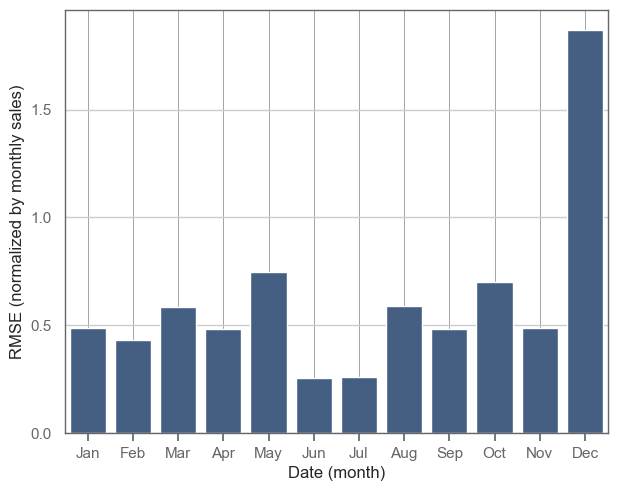

In [33]:
ax = sns.barplot(x="date", y="RMSE_norm", data=rmse_monthly)
ax.set_xticklabels(rmse_monthly["date"].dt.strftime("%b"))
ax.set_yticks(np.arange(0, 1.6, 0.5))
ax.set_xlabel("Date (month)")
ax.set_ylabel("RMSE (normalized by monthly sales)")
plt.grid(axis="x", color="gray", linestyle="-", linewidth=0.5)
plt.show()

In [34]:
plotdata = (
    data_holdout.filter(["date", "month", "QUANTITY", "y_hat_5"])
    .melt(id_vars=["date", "month"])
    .merge(data_holdout.filter(["date", "QUANTITY"]), on="date")
    .merge(data_holdout.filter(["date", "y_hat_5"]), on="date")
    .rename(columns={"QUANTITY": "ymin", "y_hat_5": "ymax"})
    .assign(
        variable=lambda x: x["variable"].map(
            {"QUANTITY": "Actual", "y_hat_5": "Predicted"}
        )
    )
)

### Figure 18.6

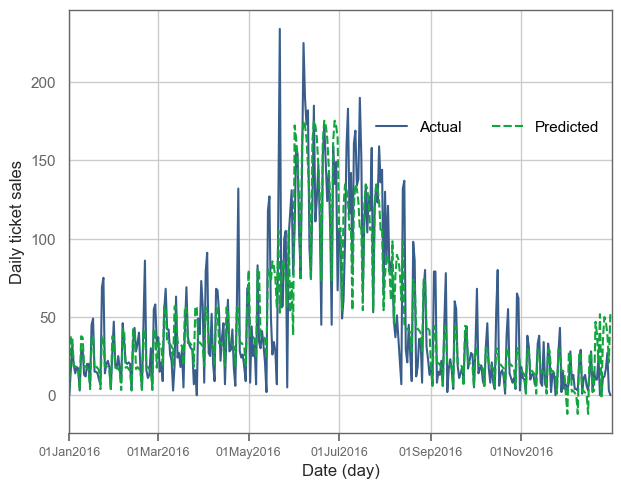

In [35]:
sns.lineplot(x="date", y="value", hue="variable", style="variable", data=plotdata)

xticks = pd.to_datetime(
    ["2016-01-01", "2016-03-01", "2016-05-01", "2016-07-01", "2016-09-01", "2016-11-01"]
)
xlabels = ["01Jan2016", "01Mar2016", "01May2016", "01Jul2016", "01Sep2016", "01Nov2016"]
plt.xticks(xticks, labels=xlabels, fontsize=9)
plt.xlim((datetime(2016, 1, 1), datetime(2017, 1, 1)))
plt.xlabel("Date (day)")
plt.ylabel("Daily ticket sales")
plt.legend(bbox_to_anchor=(0.54, 0.77), frameon=False, ncol=2)
plt.show()

### Figure 18.7 a)

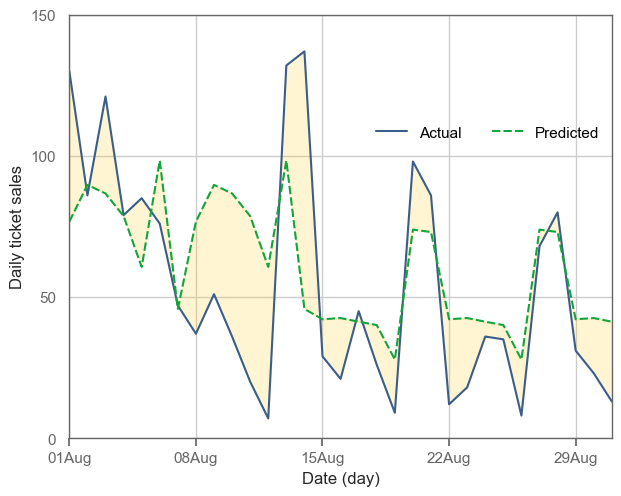

In [36]:
plotdata_august = plotdata[plotdata["month"] == 8].reset_index()
sns.lineplot(
    x="date",
    y="value",
    hue="variable",
    style="variable",
    data=plotdata_august,
    linewidth=1.5,
)

plt.fill_between(
    plotdata_august.loc[lambda x: x["variable"] == "Actual", "date"],
    plotdata_august.loc[lambda x: x["variable"] == "Actual", "ymin"],
    plotdata_august.loc[lambda x: x["variable"] == "Actual", "ymax"],
    color=da.color[3],
    alpha=0.2,
)
plt.xticks(
    pd.to_datetime(
        ["2016-08-01", "2016-08-08", "2016-08-15", "2016-08-22", "2016-08-29"]
    ),
    labels=["01Aug", "08Aug", "15Aug", "22Aug", "29Aug"],
)
plt.ylim(0, 150)
plt.xlim((datetime(2016, 8, 1), datetime(2016, 8, 31)))
plt.yticks(np.arange(0, 151, 50))
plt.xlabel("Date (day)")
plt.ylabel("Daily ticket sales")
plt.legend(
    title="", loc="upper left", bbox_to_anchor=(0.54, 0.77), frameon=False, ncol=2
)

plt.show()